In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when, concat_ws
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.mllib.evaluation import MulticlassMetrics

# Initialiser la session Spark
spark = SparkSession.builder \
    .appName('SpamDetection') \
    .master('local[*]') \
    .getOrCreate()


In [3]:
# ===== CHARGEMENT DES DONNÉES =====
# Charger le fichier
df_raw = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .csv("/content/drive/MyDrive/spam.csv")

In [4]:
# ===== RENOMMER v1 -> label et v2 -> texte =====

if "v1" in df_raw.columns and "v2" in df_raw.columns:
    print("\n✓ Colonnes v1 et v2 détectées")

    # Vérifier s'il y a d'autres colonnes (v2,,,)
    if len(df_raw.columns) == 2:
        # Cas simple: seulement v1 et v2
        df = df_raw.select(
            col("v1").alias("label"),
            col("v2").alias("texte")
        )
    else:
        # Il y a plusieurs colonnes pour le texte
        print(f"Nombre total de colonnes: {len(df_raw.columns)}")

        # Combiner toutes les colonnes de texte (v2, les colonnes vides, etc.)
        colonnes_texte = [c for c in df_raw.columns if c != "v1"]

        df = df_raw.select(
            col("v1").alias("label"),
            concat_ws(" ", *[col(c) for c in colonnes_texte]).alias("texte")
        )

        # Nettoyer les espaces multiples et "null" textuels
        from pyspark.sql.functions import regexp_replace, trim
        df = df.withColumn("texte", regexp_replace(col("texte"), "null", ""))
        df = df.withColumn("texte", regexp_replace(col("texte"), "\\s+", " "))
        df = df.withColumn("texte", trim(col("texte")))

else:
    print("⚠️ Format non reconnu. Colonnes disponibles:", df_raw.columns)
    # Utiliser les premières colonnes disponibles
    colonnes = df_raw.columns
    df = df_raw.select(
        col(colonnes[0]).alias("label"),
        col(colonnes[1]).alias("texte")
    )

print("\n=== Après renommage ===")
df.show(5, truncate=50)
df.printSchema()



✓ Colonnes v1 et v2 détectées
Nombre total de colonnes: 5

=== Après renommage ===
+-----+--------------------------------------------------+
|label|                                             texte|
+-----+--------------------------------------------------+
|  ham|Go until jurong point, crazy.. Available only i...|
|  ham|                     Ok lar... Joking wif u oni...|
| spam|Free entry in 2 a wkly comp to win FA Cup final...|
|  ham| U dun say so early hor... U c already then say...|
|  ham|Nah I don't think he goes to usf, he lives arou...|
+-----+--------------------------------------------------+
only showing top 5 rows

root
 |-- label: string (nullable = true)
 |-- texte: string (nullable = false)



In [5]:
# ===== CONVERSION DES LABELS =====
print("\n=== Conversion des labels ===")
print("Labels uniques avant conversion:")
df.select("label").distinct().show()

# Convertir ham/spam en 0/1
df = df.withColumn("label",
    when(col("label").isin(["spam", "1", "1.0"]), 1.0)
    .when(col("label").isin(["ham", "0", "0.0"]), 0.0)
    .otherwise(col("label").cast("double"))
)

print("\nLabels après conversion:")
df.select("label").distinct().show()


=== Conversion des labels ===
Labels uniques avant conversion:
+------+
| label|
+------+
|ham"""|
|   ham|
|  spam|
+------+


Labels après conversion:
+-----+
|label|
+-----+
|  0.0|
|  1.0|
| NULL|
+-----+



In [6]:
# ===== NETTOYAGE =====
print("\n=== Nettoyage des données ===")
print(f"Lignes avant nettoyage: {df.count()}")

df = df.dropna()
df = df.filter((col("texte") != "") & (col("texte").isNotNull()))
df = df.filter(col("texte").rlike(".+"))  # Au moins un caractère

print(f"Lignes après nettoyage: {df.count()}")

# Vérifier la distribution
print("\n=== Distribution des labels ===")
df.groupBy("label").count().show()

# Afficher quelques exemples
print("\n=== Exemples de données ===")
df.select("label", "texte").show(10, truncate=50)


=== Nettoyage des données ===
Lignes avant nettoyage: 5574
Lignes après nettoyage: 5572

=== Distribution des labels ===
+-----+-----+
|label|count|
+-----+-----+
|  0.0| 4825|
|  1.0|  747|
+-----+-----+


=== Exemples de données ===
+-----+--------------------------------------------------+
|label|                                             texte|
+-----+--------------------------------------------------+
|  0.0|Go until jurong point, crazy.. Available only i...|
|  0.0|                     Ok lar... Joking wif u oni...|
|  1.0|Free entry in 2 a wkly comp to win FA Cup final...|
|  0.0| U dun say so early hor... U c already then say...|
|  0.0|Nah I don't think he goes to usf, he lives arou...|
|  1.0|FreeMsg Hey there darling it's been 3 week's no...|
|  0.0|Even my brother is not like to speak with me. T...|
|  0.0|As per your request 'Melle Melle (Oru Minnaminu...|
|  1.0|WINNER!! As a valued network customer you have ...|
|  1.0|Had your mobile 11 months or more? U R entitled..

In [7]:
# ===== VÉRIFICATION DES DEUX CLASSES =====
label_counts = df.groupBy("label").count().collect()
labels_present = [row['label'] for row in label_counts]

if len(labels_present) < 2:
    print("\n⚠️ PROBLÈME: Une seule classe détectée!")
    print("Labels présents:", labels_present)
    print("\nVérifiez le fichier source. Le dataset SMS Spam doit avoir:")
    print("- Des messages 'ham' (non-spam, label=0)")
    print("- Des messages 'spam' (spam, label=1)")
else:
    print("\n✓ Parfait! Les deux classes sont présentes")

    # ===== DIVISION DES DONNÉES =====
    (trainingData, testData) = df.randomSplit([0.7, 0.3], seed=42)
    print(f"\nDonnées d'entraînement: {trainingData.count()}")
    print(f"Données de test: {testData.count()}")

    # ===== PIPELINE ET ENTRAÎNEMENT =====
    from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
    from pyspark.ml.classification import NaiveBayes
    from pyspark.ml import Pipeline

    print("\n=== Création du pipeline Naive Bayes ===")

    regexTokenizer = RegexTokenizer(
        inputCol="texte",
        outputCol="mots",
        pattern="\\W"
    )

    stopwordsRemover = StopWordsRemover(
        inputCol="mots",
        outputCol="mots_filtres"
    )

    countVectors = CountVectorizer(
        inputCol="mots_filtres",
        outputCol="features_brutes",
        vocabSize=10000,
        minDF=5
    )

    idf = IDF(
        inputCol="features_brutes",
        outputCol="features"
    )

    nb = NaiveBayes(
        labelCol="label",
        featuresCol="features",
        smoothing=1.0,
        modelType="multinomial"
    )

    pipeline_nb = Pipeline(stages=[
        regexTokenizer,
        stopwordsRemover,
        countVectors,
        idf,
        nb
    ])


✓ Parfait! Les deux classes sont présentes

Données d'entraînement: 3979
Données de test: 1593

=== Création du pipeline Naive Bayes ===


In [8]:
 # Entraînement
model_nb = pipeline_nb.fit(trainingData)
predictions_nb = model_nb.transform(testData)
print("✓ Modèle Naive Bayes entraîné avec succès!")

    # Évaluation

evaluator_accuracy = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )

evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )

accuracy = evaluator_accuracy.evaluate(predictions_nb)
f1_score = evaluator_f1.evaluate(predictions_nb)

print(f"\n=== RÉSULTATS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")

    # Exemples de prédictions
print("\n=== Exemples de prédictions ===")
predictions_nb.select("texte", "label", "prediction").show(10, truncate=50)

✓ Modèle Naive Bayes entraîné avec succès!

=== RÉSULTATS ===
Accuracy: 0.9724
F1-Score: 0.9730

=== Exemples de prédictions ===
+--------------------------------------------------+-----+----------+
|                                             texte|label|prediction|
+--------------------------------------------------+-----+----------+
|"7 wonders in My WORLD 7th You 6th Ur style 5th...|  0.0|       0.0|
|"A swt thought: \Nver get tired of doing little...|  0.0|       0.0|
|"And that is the problem. You walk around in \j...|  0.0|       0.0|
|"Awesome question with a cute answer: Someone a...|  0.0|       0.0|
|"Beautiful Truth against Gravity.. Read careful...|  0.0|       0.0|
|"Best line said in Love: . \I will wait till th...|  0.0|       0.0|
|"Cool breeze... Bright sun... Fresh flower... T...|  0.0|       0.0|
|"Feb &lt;#&gt; is \I LOVE U"" day. Send dis to ...|  0.0|       0.0|
|"Finally it has happened..! Aftr decades..! BEE...|  0.0|       0.0|
|"GOD ASKED, \What is forgivene

In [9]:
# ===== MODÈLE 2: RANDOM FOREST =====
from pyspark.ml.classification import RandomForestClassifier

print("\n" + "="*60)
print("=== ENTRAÎNEMENT RANDOM FOREST ===")
print("="*60)

rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=100,
    maxDepth=10,
    seed=42
)

pipeline_rf = Pipeline(stages=[
    regexTokenizer,
    stopwordsRemover,
    countVectors,
    idf,
    rf
])

print("\nEntraînement en cours...")
model_rf = pipeline_rf.fit(trainingData)
predictions_rf = model_rf.transform(testData)
print("✓ Random Forest entraîné avec succès!")

# Évaluation
accuracy_rf = evaluator_accuracy.evaluate(predictions_rf)
f1_rf = evaluator_f1.evaluate(predictions_rf)

print(f"\nRandom Forest:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")

# ===== MODÈLE 3: LOGISTIC REGRESSION =====
from pyspark.ml.classification import LogisticRegression

print("\n" + "="*60)
print("=== ENTRAÎNEMENT LOGISTIC REGRESSION ===")
print("="*60)

lr = LogisticRegression(
    labelCol="label",
    featuresCol="features",
    maxIter=20,
    regParam=0.3,
    elasticNetParam=0.8
)

pipeline_lr = Pipeline(stages=[
    regexTokenizer,
    stopwordsRemover,
    countVectors,
    idf,
    lr
])

print("\nEntraînement en cours...")
model_lr = pipeline_lr.fit(trainingData)
predictions_lr = model_lr.transform(testData)
print("✓ Logistic Regression entraînée avec succès!")

# Évaluation
accuracy_lr = evaluator_accuracy.evaluate(predictions_lr)
f1_lr = evaluator_f1.evaluate(predictions_lr)

print(f"\nLogistic Regression:")
print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  F1-Score: {f1_lr:.4f}")



=== ENTRAÎNEMENT RANDOM FOREST ===

Entraînement en cours...
✓ Random Forest entraîné avec succès!

Random Forest:
  Accuracy: 0.9353
  F1-Score: 0.9262

=== ENTRAÎNEMENT LOGISTIC REGRESSION ===

Entraînement en cours...
✓ Logistic Regression entraînée avec succès!

Logistic Regression:
  Accuracy: 0.8663
  F1-Score: 0.8042


In [10]:
# ===== COMPARAISON DES MODÈLES =====
print("=== COMPARAISON DES 3 MODÈLES ===")


# Liste des modèles avec leurs prédictions
modeles = [
    ("Naive Bayes", predictions_nb),
    ("Random Forest", predictions_rf),
    ("Logistic Regression", predictions_lr)
]

# Métriques à calculer
metriques = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

# Tableau de résultats
resultats = []

for nom_modele, predictions in modeles:
    print(f"\n{nom_modele}:")
    resultats_modele = {"Modèle": nom_modele}

    for metrique in metriques:
        evaluator = MulticlassClassificationEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName=metrique
        )
        score = evaluator.evaluate(predictions)
        resultats_modele[metrique.replace("weighted", "")] = score
        print(f"  {metrique}: {score:.4f}")

    resultats.append(resultats_modele)

# Afficher un tableau de comparaison
print("\n" + "="*60)
print("TABLEAU RÉCAPITULATIF")
print("="*60)
print(f"{'Modèle':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 73)

for r in resultats:
    print(f"{r['Modèle']:<25} {r['accuracy']:<12.4f} {r['Precision']:<12.4f} {r['Recall']:<12.4f} {r['f1']:<12.4f}")

# Identifier le meilleur modèle
meilleur = max(resultats, key=lambda x: x['f1'])
print(f"\n✓ Meilleur modèle: {meilleur['Modèle']} (F1-Score: {meilleur['f1']:.4f})")


=== COMPARAISON DES 3 MODÈLES ===

Naive Bayes:
  accuracy: 0.9724
  weightedPrecision: 0.9744
  weightedRecall: 0.9724
  f1: 0.9730

Random Forest:
  accuracy: 0.9353
  weightedPrecision: 0.9398
  weightedRecall: 0.9353
  f1: 0.9262

Logistic Regression:
  accuracy: 0.8663
  weightedPrecision: 0.7505
  weightedRecall: 0.8663
  f1: 0.8042

TABLEAU RÉCAPITULATIF
Modèle                    Accuracy     Precision    Recall       F1-Score    
-------------------------------------------------------------------------
Naive Bayes               0.9724       0.9744       0.9724       0.9730      
Random Forest             0.9353       0.9398       0.9353       0.9262      
Logistic Regression       0.8663       0.7505       0.8663       0.8042      

✓ Meilleur modèle: Naive Bayes (F1-Score: 0.9730)



=== VISUALISATION DES MATRICES DE CONFUSION ===


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


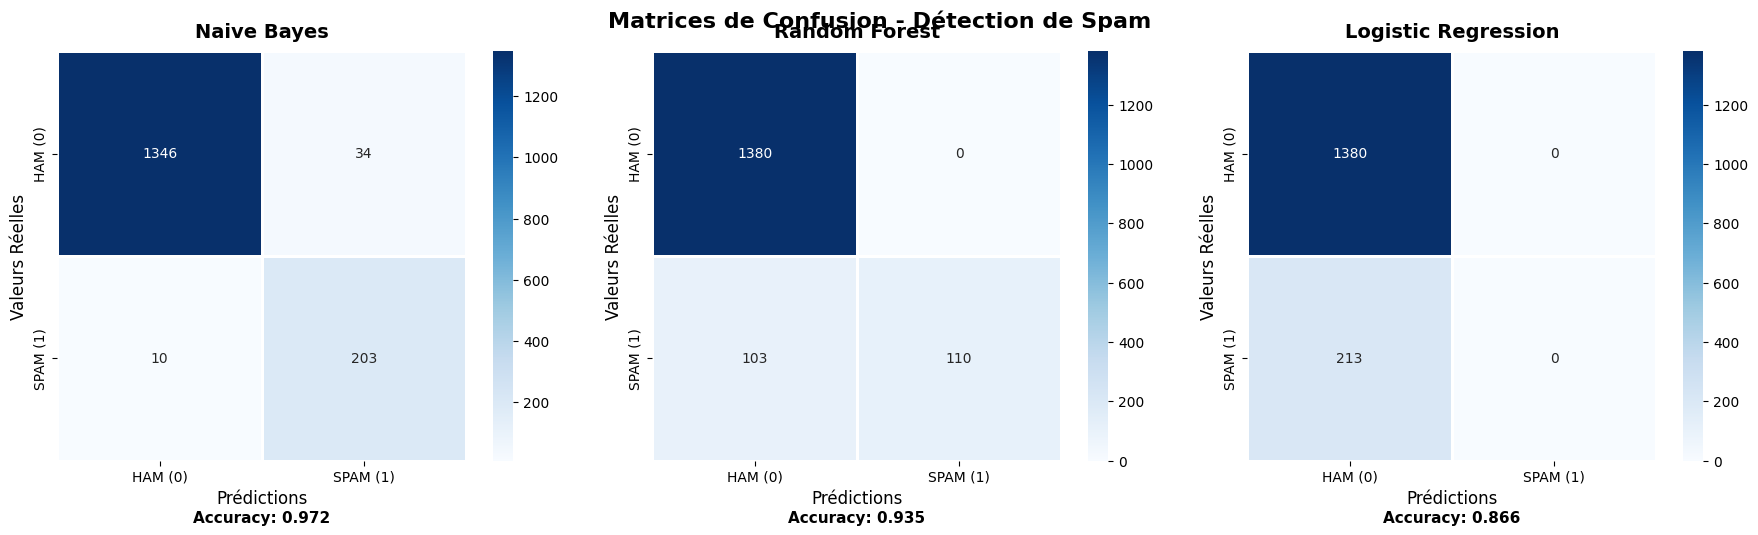


✓ Graphiques sauvegardés dans le Drive!


In [11]:
# ===== VISUALISATION DES MATRICES DE CONFUSION =====
print("\n" + "="*60)
print("=== VISUALISATION DES MATRICES DE CONFUSION ===")
print("="*60)

# Liste des modèles
modeles = [
    ("Naive Bayes", predictions_nb),
    ("Random Forest", predictions_rf),
    ("Logistic Regression", predictions_lr)
]

# Créer une figure avec 3 sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusion - Détection de Spam', fontsize=16, fontweight='bold')

for idx, (nom_modele, predictions) in enumerate(modeles):
    # Extraire la matrice de confusion
    predictionAndLabels = predictions.select("prediction", "label") \
        .rdd.map(lambda x: (float(x[0]), float(x[1])))

    metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = metrics.confusionMatrix().toArray()

    # Créer le heatmap avec Seaborn
    sns.heatmap(
        confusion_matrix,
        annot=True,           # Afficher les nombres
        fmt='.0f',            # Format entier
        cmap='Blues',         # Palette de couleurs
        cbar=True,            # Barre de couleur
        square=True,          # Cellules carrées
        linewidths=2,         # Lignes entre cellules
        linecolor='white',    # Couleur des lignes
        ax=axes[idx],         # Axe à utiliser
        xticklabels=['HAM (0)', 'SPAM (1)'],
        yticklabels=['HAM (0)', 'SPAM (1)']
    )

    # Personnaliser le graphique
    axes[idx].set_title(f'{nom_modele}', fontsize=14, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Prédictions', fontsize=12)
    axes[idx].set_ylabel('Valeurs Réelles', fontsize=12)

    # Ajouter les métriques sous le graphique
    tn, fp, fn, tp = confusion_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    axes[idx].text(
        0.5, -0.15,
        f'Accuracy: {accuracy:.3f}',
        transform=axes[idx].transAxes,
        ha='center',
        fontsize=11,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphiques sauvegardés dans le Drive!")


In [12]:
# ===== TEST AVEC LE MODÈLE NAIVE BAYES =====
print("\n" + "="*60)
print("=== TEST SUR NOUVEAUX EMAILS - NAIVE BAYES ===")
print("="*60)

# Créer des exemples d'emails à tester
nouveaux_emails = spark.createDataFrame([
    (1, "WINNER! You've won $1000 cash prize. Click here to claim now!"),
    (2, "Hi John, can we schedule our meeting for tomorrow at 3pm?"),
    (3, "URGENT: Your bank account has been suspended. Verify immediately!"),
    (4, "Thanks for your email. I'll review the document and get back to you."),
    (5, "Congratulations! FREE iPhone 15 waiting for you. Act now!"),
    (6, "Meeting notes from today are attached. Let me know if you have questions."),
    (7, "CALL NOW to claim your FREE vacation to Bahamas!!!"),
    (8, "Hi team, please find the quarterly report in the attachment."),
    (9, "You have been selected for a special offer. Click here for details."),
    (10, "Reminder: Your dentist appointment is tomorrow at 2pm.")
], ["id", "texte"])

print("\n=== Prédictions avec Naive Bayes (F1-Score: 0.9730) ===\n")

# Faire les prédictions
predictions_nouveaux = model_nb.transform(nouveaux_emails)

# Afficher les résultats de manière détaillée
for row in predictions_nouveaux.select("id", "texte", "prediction", "probability").collect():
    prediction_label = "SPAM ⚠️" if row['prediction'] == 1.0 else "HAM ✅"
    spam_prob = float(row['probability'][1]) * 100
    ham_prob = float(row['probability'][0]) * 100

    # Couleur selon la prédiction
    if row['prediction'] == 1.0:
        color = "🔴"
    else:
        color = "🟢"

    print(f"{color} [Email #{row['id']}]")
    print(f"   Texte: {row['texte']}")
    print(f"   Prédiction: {prediction_label}")
    print(f"   Confiance SPAM: {spam_prob:.2f}% | HAM: {ham_prob:.2f}%")
    print("-" * 80)

# Afficher un résumé
print("\n=== RÉSUMÉ DES PRÉDICTIONS ===")
summary = predictions_nouveaux.groupBy("prediction").count().collect()

for row in summary:
    label = "SPAM" if row['prediction'] == 1.0 else "HAM"
    print(f"{label}: {row['count']} emails")



=== TEST SUR NOUVEAUX EMAILS - NAIVE BAYES ===

=== Prédictions avec Naive Bayes (F1-Score: 0.9730) ===

🔴 [Email #1]
   Texte: WINNER! You've won $1000 cash prize. Click here to claim now!
   Prédiction: SPAM ⚠️
   Confiance SPAM: 100.00% | HAM: 0.00%
--------------------------------------------------------------------------------
🟢 [Email #2]
   Texte: Hi John, can we schedule our meeting for tomorrow at 3pm?
   Prédiction: HAM ✅
   Confiance SPAM: 0.00% | HAM: 100.00%
--------------------------------------------------------------------------------
🔴 [Email #3]
   Texte: URGENT: Your bank account has been suspended. Verify immediately!
   Prédiction: SPAM ⚠️
   Confiance SPAM: 100.00% | HAM: 0.00%
--------------------------------------------------------------------------------
🟢 [Email #4]
   Texte: Thanks for your email. I'll review the document and get back to you.
   Prédiction: HAM ✅
   Confiance SPAM: 0.00% | HAM: 100.00%
--------------------------------------------------------

In [13]:
# ===== SAUVEGARDER LE MEILLEUR MODÈLE =====
print("\n=== SAUVEGARDE DU MODÈLE NAIVE BAYES ===")

model_path = "/content/drive/MyDrive/spam_detection_naive_bayes_best"

try:
    model_nb.write().overwrite().save(model_path)
    print(f"✓ Modèle Naive Bayes sauvegardé avec succès!")
    print(f"Chemin: {model_path}")
    print(f"Performance: F1-Score = 0.9730")

    # Vérifier le chargement
    from pyspark.ml import PipelineModel
    loaded_model = PipelineModel.load(model_path)
    print("✓ Vérification: Modèle rechargé avec succès!")

except Exception as e:
    print(f"❌ Erreur: {e}")




=== SAUVEGARDE DU MODÈLE NAIVE BAYES ===
✓ Modèle Naive Bayes sauvegardé avec succès!
Chemin: /content/drive/MyDrive/spam_detection_naive_bayes_best
Performance: F1-Score = 0.9730
✓ Vérification: Modèle rechargé avec succès!
